In [1]:
import pandas as pd
import numpy as np
import math
import quandl as qd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = qd.get("NSE/POWERGRID", authtoken="gmWv5h5b4KEUxUbiSneX")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2773 entries, 2007-10-05 to 2018-12-17
Data columns (total 7 columns):
Open                    2773 non-null float64
High                    2773 non-null float64
Low                     2773 non-null float64
Last                    2773 non-null float64
Close                   2773 non-null float64
Total Trade Quantity    2773 non-null float64
Turnover (Lacs)         2773 non-null float64
dtypes: float64(7)
memory usage: 173.3 KB


In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2773 entries, 2007-10-05 to 2018-12-17
Data columns (total 7 columns):
Open                    2773 non-null float64
High                    2773 non-null float64
Low                     2773 non-null float64
Last                    2773 non-null float64
Close                   2773 non-null float64
Total Trade Quantity    2773 non-null float64
Turnover (Lacs)         2773 non-null float64
dtypes: float64(7)
memory usage: 173.3 KB


In [6]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2.773000e+03,2773.000000
mean,131.420303,133.097007,129.517743,131.295150,131.300018,5.167660e+06,6894.396859
std,38.649289,38.796675,38.441220,38.571812,38.582837,1.289703e+07,14968.104879
min,61.700000,62.000000,52.000000,59.150000,58.000000,3.406300e+04,38.250000
25%,102.100000,103.700000,100.700000,102.300000,102.150000,2.124667e+06,2360.820000
50%,113.600000,115.000000,111.900000,113.350000,113.300000,3.391462e+06,4217.690000
75%,149.000000,150.950000,146.700000,148.850000,148.550000,5.539334e+06,7746.170000
max,226.500000,226.600000,223.000000,225.500000,225.950000,4.810589e+08,493056.070000


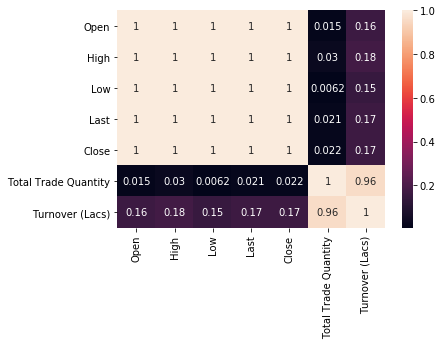

In [7]:
plt.figure(1)
sns.heatmap(df.corr(), annot=True)
plt.show()

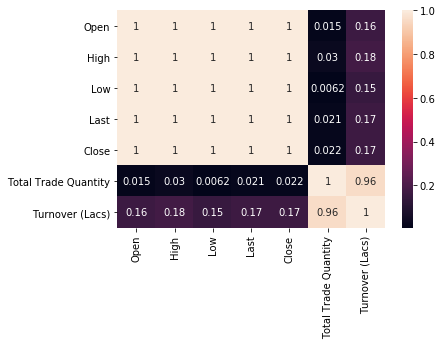

In [8]:
plt.figure(1)
sns.heatmap(df.corr(), annot=True)
plt.show()

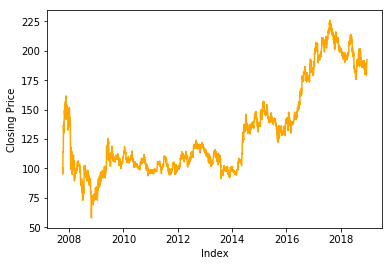

In [9]:
plt.figure(3)
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.plot(df.Close, color='orange')
plt.show()

In [10]:
df_temp = df[['Open', 'High', 'Low', 'Close', 'Total Trade Quantity']]
df_temp['HLP'] = (df_temp['High'] - df_temp['Close']) / df_temp['Close'] * 100.0
df_temp['Change'] = (df_temp['Close'] - df_temp['Open']) / df_temp['Open'] * 100
df_temp['EPS'] = (df['Turnover (Lacs)']*100000)/df['Total Trade Quantity']
df_temp['PE'] = df_temp['Close']/df_temp['EPS']

df_use = df_temp[['Close', 'HLP', 'Change', 'Total Trade Quantity', 'EPS', 'PE']]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
df_use.head()

,Close,HLP,Change,Total Trade Quantity,EPS,PE
Date,,,,,,
2007-10-05,100.60,8.846918,12.026726,481058927.0,102.493903,0.981522
2007-10-08,95.45,8.957569,-8.221154,71252858.0,98.124008,0.972749
2007-10-09,101.95,0.882786,6.753927,65658228.0,98.567753,1.034314
2007-10-10,102.90,2.040816,-1.625239,38211410.0,103.657180,0.992695
2007-10-11,114.40,4.895105,-4.666667,59805552.0,110.779598,1.032681


In [12]:
forecast_col = 'Close'

forecast_out = int(math.ceil(0.01*len(df_use)))

df_use['Label'] = df_use[forecast_col].shift(-forecast_out)

df_use.dropna(inplace=True)

df_use.tail()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Close,HLP,Change,Total Trade Quantity,EPS,PE,Label
Date,,,,,,,
2018-10-30,186.15,1.826484,-1.507937,2871863.0,186.978627,0.995568,180.30
2018-10-31,185.95,0.430223,0.459211,5412453.0,184.345989,1.008701,182.55
2018-11-01,188.45,0.451048,1.262762,3151762.0,186.726028,1.009233,182.55
2018-11-02,189.85,1.290492,0.423168,3394386.0,190.506619,0.996553,185.70
2018-11-05,186.05,1.854340,-1.586882,2740960.0,185.965501,1.000454,192.55


In [13]:
print('We are predicting "', forecast_out, '" days into the future')

We are predicting " 28 " days into the future


In [14]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2745 entries, 2007-10-05 to 2018-11-05
Data columns (total 7 columns):
Close                   2745 non-null float64
HLP                     2745 non-null float64
Change                  2745 non-null float64
Total Trade Quantity    2745 non-null float64
EPS                     2745 non-null float64
PE                      2745 non-null float64
Label                   2745 non-null float64
dtypes: float64(7)
memory usage: 171.6 KB


In [15]:
X = df_use
X = X.drop(['Label'], 1)
#X = preprocessing.scale(X)

y = df_use['Label']

print(X.shape, y.shape)

(2745, 6) (2745,)


In [16]:
 #X = np.array(df_use.drop(['label'], 1))
 #y = np.array(df_use['label'])

 #X = preprocessing.scale(X)
 #print(X.shape, Y.shape)

In [17]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

from sklearn import preprocessing
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2196, 6) (2196,)
(549, 6) (549,)


#### RBF Kernel

In [18]:
clf_rbf = svm.SVR(kernel='rbf', gamma='auto', C=1.0)
clf_rbf.fit(X_train, y_train)

accuracy_rbf = clf_rbf.score(X_test, y_test)

print(accuracy_rbf)

0.9104644525373952


#### Linear Kernel

In [19]:
#clf_lin = BaggingClassifier(svm.SVR(kernel='linear', gamma='auto', C=1.0), n_jobs=-1)
clf_lin = svm.SVR(kernel= 'linear', C= 1e3)
clf_lin.fit(X_train, y_train)

accuracy_lin = clf_lin.score(X_test, y_test)

print(accuracy_lin)

0.942676487183157


#### Sigmoid Kernel

In [20]:
clf_sig = svm.SVR(kernel='sigmoid', gamma='auto', C=1.0)
clf_sig.fit(X_train, y_train)

accuracy_sig = clf_sig.score(X_test, y_test)

print(accuracy_sig)

-0.3738388574533771


#### Poly Kernel

In [21]:
clf_poly_1 = svm.SVR(kernel='poly', gamma='auto', C=1.0, degree=1)
clf_poly_1.fit(X_train, y_train)

accuracy_poly_1 = clf_poly_1.score(X_test, y_test)

print(accuracy_poly_1)

0.9424672403189521


In [22]:
clf_poly_2 = svm.SVR(kernel='poly', gamma='auto', C=1.0, degree=2)
clf_poly_2.fit(X_train, y_train)

accuracy_poly_2 = clf_poly_2.score(X_test, y_test)

print(accuracy_poly_2)

0.5166900875142619


In [23]:
clf_poly_3 = svm.SVR(kernel='poly', gamma='auto', C=1.0, degree=3)
clf_poly_3.fit(X_train, y_train)

accuracy_poly_3 = clf_poly_3.score(X_test, y_test)

print(accuracy_poly_3)

0.6914035616886839


In [24]:
clf_poly_4 = svm.SVR(kernel='poly', gamma='auto', C=1.0, degree=4)
clf_poly_4.fit(X_train, y_train)

accuracy_poly_4 = clf_poly_4.score(X_test, y_test)

print(accuracy_poly_4)

0.46296081339892525


### Result Comparison

In [25]:
kernels = ['Linear', 'Poly_1', 'Poly_2', 'Poly_3', 'Poly_4', 'RBF', 'Sigmoid']

accuracy = []
accuracy.append(accuracy_lin*100)
accuracy.append(accuracy_poly_1*100)
accuracy.append(accuracy_poly_2*100)
accuracy.append(accuracy_poly_3*100)
accuracy.append(accuracy_poly_4*100)
accuracy.append(accuracy_rbf*100)
accuracy.append(accuracy_sig*100)

print(kernels)
print(accuracy)

['Linear', 'Poly_1', 'Poly_2', 'Poly_3', 'Poly_4', 'RBF', 'Sigmoid']
[94.2676487183157, 94.24672403189521, 51.66900875142619, 69.1403561688684, 46.296081339892524, 91.04644525373952, -37.38388574533771]


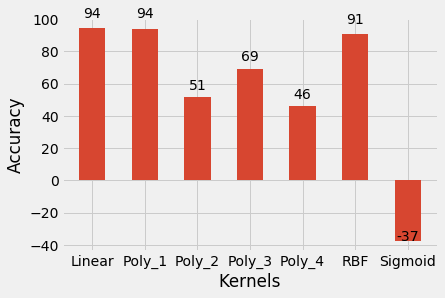

In [26]:
plt.style.use('fivethirtyeight')
rects = plt.bar(kernels, accuracy, width=0.5, color='#D74630',
       animated=True)
plt.xlabel('Kernels')
plt.ylabel('Accuracy')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
autolabel(rects)


plt.show()